<a href="https://colab.research.google.com/github/deissytvanegasmo-glitch/Repositorio-1-Sistemas-avanzados-/blob/main/Taller_1_Vanegas_Deissy_90886.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clase 2 (2h): Estadística descriptiva y visualización (univariado y bivariado)

**Objetivos**
- Describir variables numéricas y categóricas.
- Detectar atípicos (regla 1.5·IQR).
- Visualizar con histogramas, cajas y barras.
- Explorar relaciones bivariadas: numérico↔numérico y categórico↔categórico.


In [ ]:

import sys, platform, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
print("Python:", sys.version.split()[0], "|", platform.platform())


Python: 3.12.11 | Linux-6.1.123+-x86_64-with-glibc2.35


In [ ]:

# Dataset base (si no existe 'df')
if 'df' not in globals():
    np.random.seed(42)
    n = 800
    df = pd.DataFrame({
        "SEQN": np.arange(1, n+1),
        "RIAGENDR": np.random.choice([1, 2], size=n),
        "RIDAGEYR": np.random.randint(18, 80, size=n),
        "BMXWT": np.round(np.random.normal(71, 13, size=n), 1),
        "BMXHT": np.round(np.random.normal(168, 9, size=n), 1),
    })
    df["BMXBMI"] = np.round(df["BMXWT"] / (df["BMXHT"]/100)**2, 1)
    df.loc[np.random.choice(df.index, size=20, replace=False), "BMXWT"] = np.nan

# Recodificar
if "RIAGENDR" in df.columns:
    df["sexo"] = df["RIAGENDR"].map({1:"Masculino", 2:"Femenino"})
if "BMXBMI" in df.columns:
    def cat_imc(x):
        if pd.isnull(x): return np.nan
        if x < 18.5: return "Bajo peso"
        if x < 25:   return "Normal"
        if x < 30:   return "Sobrepeso"
        return "Obesidad"
    df["IMC_cat"] = df["BMXBMI"].apply(cat_imc)
df.head()


,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
0,1,1,58,71.7,166.0,26.0,Masculino,Sobrepeso
1,2,2,47,85.2,165.5,31.1,Femenino,Obesidad
2,3,1,34,49.0,170.8,16.8,Masculino,Bajo peso
3,4,1,66,90.9,175.3,29.6,Masculino,Sobrepeso
4,5,1,79,68.9,175.7,22.3,Masculino,Normal


## Descriptivos univariados

In [ ]:

num_cols = df.select_dtypes(include=[np.number]).columns
resumen = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
resumen["IQR"] = resumen["75%"] - resumen["25%"]
resumen


,count,mean,std,min,25%,50%,75%,max,IQR
SEQN,800.0,400.500000,231.084400,1.0,200.75,400.50,600.250,800.0,399.500
RIAGENDR,800.0,1.517500,0.500006,1.0,1.00,2.00,2.000,2.0,1.000
RIDAGEYR,800.0,48.302500,18.050437,18.0,32.00,48.00,64.000,79.0,32.000
BMXWT,780.0,71.743846,13.033514,33.3,62.90,71.55,80.125,105.2,17.225
BMXHT,800.0,168.307375,8.829805,140.8,162.60,168.00,174.100,196.7,11.500
BMXBMI,800.0,25.581000,5.385973,11.1,21.80,25.30,28.825,48.8,7.025


In [ ]:

# Categóricas: frecuencias y proporciones
cat_cols = [c for c in df.columns if df[c].dtype == "O"]
tablas = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    prop = (vc / len(df)).round(3)
    tablas[c] = pd.DataFrame({"frecuencia": vc, "proporcion": prop})
tablas.get("IMC_cat", None)


,frecuencia,proporcion
IMC_cat,,
Normal,309,0.386
Sobrepeso,256,0.320
Obesidad,164,0.205
Bajo peso,71,0.089


## Atípicos con 1.5·IQR y visualizaciones

BMXBMI → límites [9.28, 34.91] | atípicos por abajo: 0, por arriba: 40


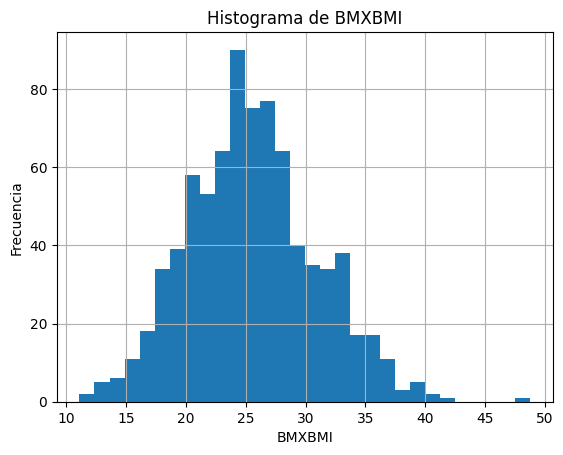

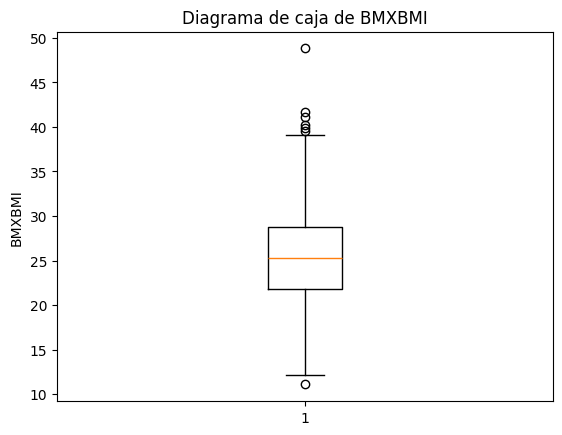

In [ ]:

def iqr_outliers(s):
    s = s.dropna()
    q1, q3 = np.percentile(s, [10, 50])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (low, high, (s < low).sum(), (s > high).sum())

target = "BMXBMI" if "BMXBMI" in df.columns else num_cols[0]
low, high, nlow, nhigh = iqr_outliers(df[target])
print(f"{target} → límites [{low:.2f}, {high:.2f}] | atípicos por abajo: {nlow}, por arriba: {nhigh}")

plt.figure(); df[target].dropna().hist(bins=30)
plt.title(f"Histograma de {target}"); plt.xlabel(target); plt.ylabel("Frecuencia"); plt.show()

plt.figure(); plt.boxplot(df[target].dropna(), vert=True)
plt.title(f"Diagrama de caja de {target}"); plt.ylabel(target); plt.show()


## Relaciones bivariadas

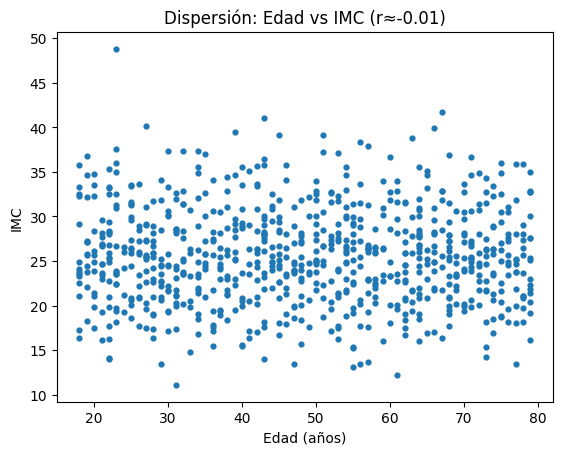

In [ ]:

# Numérico vs numérico
if {"RIDAGEYR","BMXBMI"}.issubset(df.columns):
    x, y = df["RIDAGEYR"], df["BMXBMI"]
    r = np.corrcoef(x.dropna(), y.dropna())[0,1]
    plt.figure(); plt.scatter(x, y, s=12)
    plt.title(f"Dispersión: Edad vs IMC (r≈{r:.2f})"); plt.xlabel("Edad (años)"); plt.ylabel("IMC"); plt.show()
else:
    print("No se encuentran 'RIDAGEYR' y 'BMXBMI'.")


Tabla de contingencia:
 IMC_cat    Bajo peso  Normal  Obesidad  Sobrepeso
sexo                                             
Femenino          36     170        74        134
Masculino         35     139        90        122 



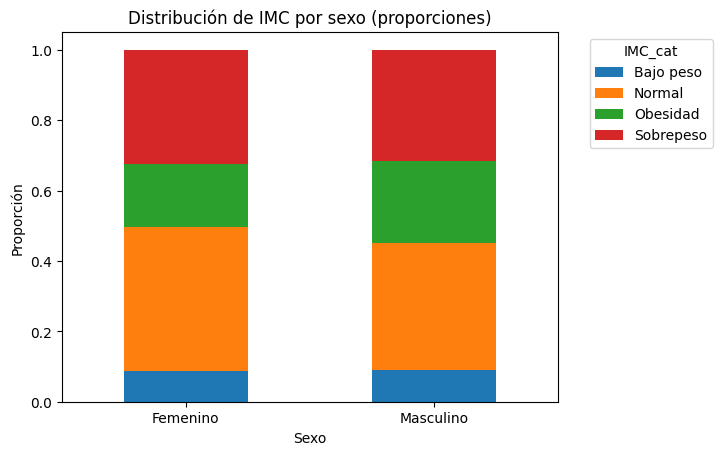

In [ ]:
    # Categórico vs categórico
    import pandas as pd, matplotlib.pyplot as plt
    if {"sexo","IMC_cat"}.issubset(df.columns):
        ct = pd.crosstab(df["sexo"], df["IMC_cat"], dropna=False)
        print("""Tabla de contingencia:
""", ct, """
""")
        (ct.T / ct.T.sum()).T.plot(kind="bar", stacked=True, rot=0)
        plt.title("Distribución de IMC por sexo (proporciones)")
        plt.xlabel("Sexo"); plt.ylabel("Proporción"); plt.legend(title="IMC_cat", bbox_to_anchor=(1.05,1), loc="upper left")
        plt.show()
    else:
        print("No se encuentran 'sexo' e 'IMC_cat'.")

## Q-Q Plot (opcional)

<Figure size 640x480 with 0 Axes>

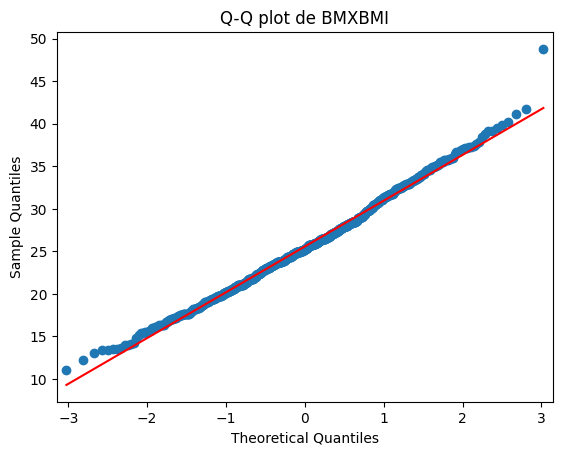

In [ ]:

import statsmodels.api as sm, matplotlib.pyplot as plt
var = "BMXBMI" if "BMXBMI" in df.columns else num_cols[0]
plt.figure(); sm.ProbPlot(df[var].dropna()).qqplot(line="s")
plt.title(f"Q-Q plot de {var}"); plt.show()



## Ejercicios (para tu repositorio)
1) Resumen de una variable numérica y detección de atípicos.  
2) Histograma y boxplot con comentario sobre la forma.  
3) Tabla `sexo × IMC_cat` con proporciones.  
4) Dispersograma de dos numéricas e interpretación de la correlación.



### Respuestas del estudiante (Markdown)
<div class="response-box">
Escribe aquí tu análisis y conclusiones para los puntos 1–4.
</div>


In [ ]:
# Respuestas del estudiante (90886)
# TODO: Añade aquí tu código para los ejercicios de la Clase 2 00000090886

In [ ]:
import sys, platform, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
print("Python:", sys.version.split()[0], "|", platform.platform())

Python: 3.12.11 | Linux-6.1.123+-x86_64-with-glibc2.35


In [ ]:
# Dataset base (si no existe 'df')
if 'df' not in globals():
    np.random.seed(42)
    n = 800
    df = pd.DataFrame({
        "SEQN": np.arange(1, n+1),
        "RIAGENDR": np.random.choice([1, 2], size=n),
        "RIDAGEYR": np.random.randint(18, 80, size=n),
        "BMXWT": np.round(np.random.normal(71, 13, size=n), 1),
        "BMXHT": np.round(np.random.normal(168, 9, size=n), 1),
    })
    df["BMXBMI"] = np.round(df["BMXWT"] / (df["BMXHT"]/100)**2, 1)
    df.loc[np.random.choice(df.index, size=20, replace=False), "BMXWT"] = np.nan

# Recodificar
if "RIAGENDR" in df.columns:
    df["sexo"] = df["RIAGENDR"].map({1:"Masculino", 2:"Femenino"})
if "BMXBMI" in df.columns:
    def cat_imc(x):
        if pd.isnull(x): return np.nan
        if x < 18.5: return "Bajo peso"
        if x < 25:   return "Normal"
        if x < 30:   return "Sobrepeso"
        return "Obesidad"
    df["IMC_cat"] = df["BMXBMI"].apply(cat_imc)
df.head()

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
0,1,1,58,71.7,166.0,26.0,Masculino,Sobrepeso
1,2,2,47,85.2,165.5,31.1,Femenino,Obesidad
2,3,1,34,49.0,170.8,16.8,Masculino,Bajo peso
3,4,1,66,90.9,175.3,29.6,Masculino,Sobrepeso
4,5,1,79,68.9,175.7,22.3,Masculino,Normal


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
resumen = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
resumen["IQR"] = resumen["75%"] - resumen["25%"]
resumen

,count,mean,std,min,25%,50%,75%,max,IQR
SEQN,800.0,400.500000,231.084400,1.0,200.75,400.50,600.250,800.0,399.500
RIAGENDR,800.0,1.517500,0.500006,1.0,1.00,2.00,2.000,2.0,1.000
RIDAGEYR,800.0,48.302500,18.050437,18.0,32.00,48.00,64.000,79.0,32.000
BMXWT,780.0,71.743846,13.033514,33.3,62.90,71.55,80.125,105.2,17.225
BMXHT,800.0,168.307375,8.829805,140.8,162.60,168.00,174.100,196.7,11.500
BMXBMI,800.0,25.581000,5.385973,11.1,21.80,25.30,28.825,48.8,7.025


In [ ]:
# Categóricas: frecuencias y proporciones
cat_cols = [c for c in df.columns if df[c].dtype == "O"]
tablas = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    prop = (vc / len(df)).round(3)
    tablas[c] = pd.DataFrame({"frecuencia": vc, "proporcion": prop})
tablas.get("IMC_cat", None)

,frecuencia,proporcion
IMC_cat,,
Normal,309,0.386
Sobrepeso,256,0.320
Obesidad,164,0.205
Bajo peso,71,0.089


BMXBMI → límites [11.26, 39.36] | atípicos por abajo: 1, por arriba: 6


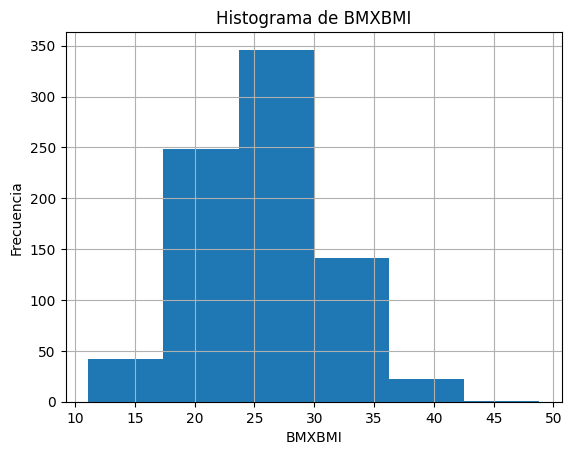

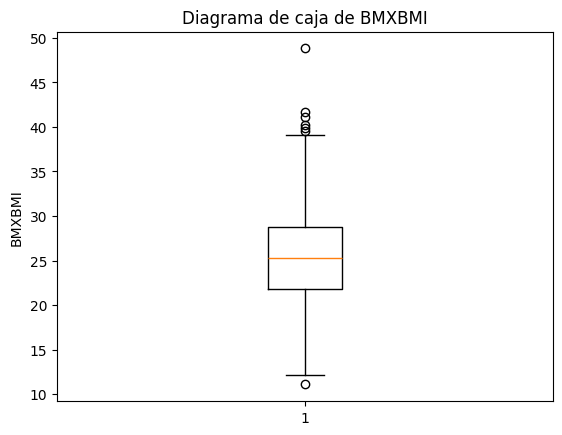

In [ ]:
def iqr_outliers(s):
    s = s.dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (low, high, (s < low).sum(), (s > high).sum())

target = "BMXBMI" if "BMXBMI" in df.columns else num_cols[0]
low, high, nlow, nhigh = iqr_outliers(df[target])
print(f"{target} → límites [{low:.2f}, {high:.2f}] | atípicos por abajo: {nlow}, por arriba: {nhigh}")

plt.figure(); df[target].dropna().hist(bins=6)
plt.title(f"Histograma de {target}"); plt.xlabel(target); plt.ylabel("Frecuencia"); plt.show()

plt.figure(); plt.boxplot(df[target].dropna(), vert=True)
plt.title(f"Diagrama de caja de {target}"); plt.ylabel(target); plt.show()

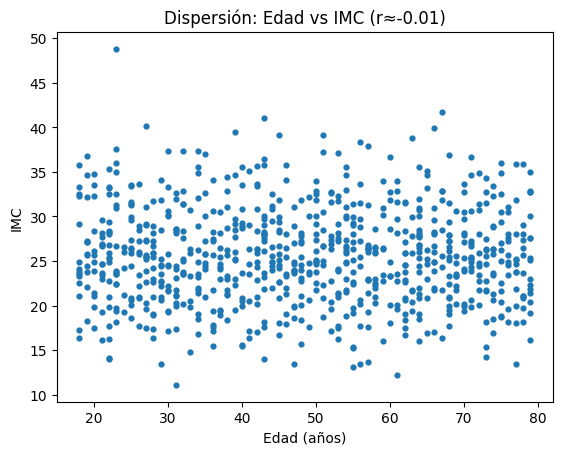

In [ ]:
# Numérico vs numérico
if {"RIDAGEYR","BMXBMI"}.issubset(df.columns):
    x, y = df["RIDAGEYR"], df["BMXBMI"]
    r = np.corrcoef(x.dropna(), y.dropna())[0,1]
    plt.figure(); plt.scatter(x, y, s=12)
    plt.title(f"Dispersión: Edad vs IMC (r≈{r:.2f})"); plt.xlabel("Edad (años)"); plt.ylabel("IMC"); plt.show()
else:
    print("No se encuentran 'RIDAGEYR' y 'BMXBMI'.")

Tabla de contingencia:
 IMC_cat    Bajo peso  Normal  Obesidad  Sobrepeso
sexo                                             
Femenino          36     170        74        134
Masculino         35     139        90        122 



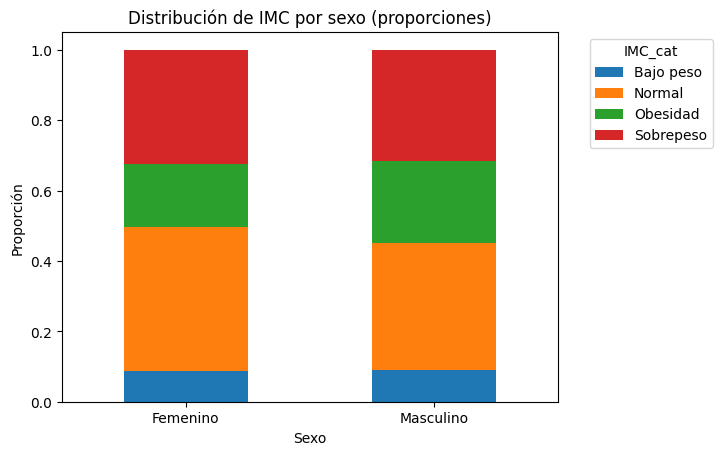

In [ ]:
# Categórico vs categórico
import pandas as pd, matplotlib.pyplot as plt
if {"sexo","IMC_cat"}.issubset(df.columns):
    ct = pd.crosstab(df["sexo"], df["IMC_cat"], dropna=False)
    print("""Tabla de contingencia:
""", ct, """
""")
    (ct.T / ct.T.sum()).T.plot(kind="bar", stacked=True, rot=0)
    plt.title("Distribución de IMC por sexo (proporciones)")
    plt.xlabel("Sexo"); plt.ylabel("Proporción"); plt.legend(title="IMC_cat", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()
else:
    print("No se encuentran 'sexo' e 'IMC_cat'.")

<Figure size 640x480 with 0 Axes>

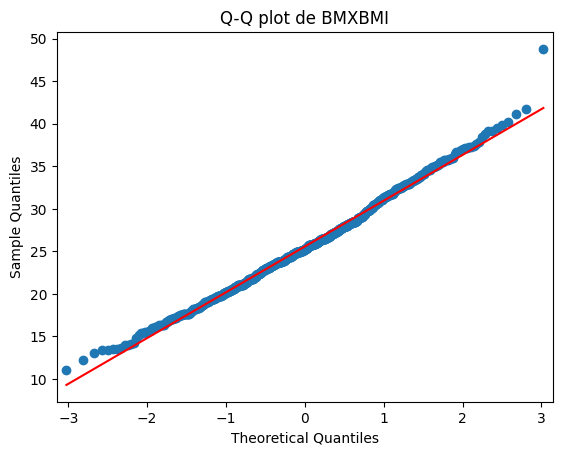

In [ ]:
import statsmodels.api as sm, matplotlib.pyplot as plt
var = "BMXBMI" if "BMXBMI" in df.columns else num_cols[0]
plt.figure(); sm.ProbPlot(df[var].dropna()).qqplot(line="s")
plt.title(f"Q-Q plot de {var}"); plt.show()

**Preguntas**

Crear cuenta en GitHub: Regístrate en https://github.com con tu correo institucional. Elige un nombre de usuario profesional y verifica tu correo.

Crear repositorio en GitHub: Crea un repositorio público (activa Add a README file). Copia y guarda el enlace del repositorio. Describe los pasos realizados.

Subir un notebook desde Colab a GitHub: Explica y realiza el proceso de Archivo → Guardar una copia en GitHub (autorización, selección de repo, mensaje de commit).

Actualizar un notebook ya guardado en GitHub: ¿Cómo guardar cambios sobre el mismo archivo en lugar de crear uno nuevo? Explica el flujo con un mensaje de commit adecuado.

TPU vs GPU en Google Colab: ¿Qué diferencia hay y cuándo se recomienda usar cada una?

Usando la base dw (wine): reporta shape, columns, dtypes, .head() y .describe().

En dw: selecciona dos variables numéricas y calcula para cada una: media, mediana, desviación estándar y cuantiles (25%, 50%, 75%).

Tabla de frecuencias: muestra cómo construir una tabla de frecuencias para una variable categórica en Pandas (value_counts()) y cómo convertirla en DataFrame.

Valores faltantes en dw: identifica las columnas con valores faltantes y muestra el conteo por columna

Subconjunto y estadísticas: en dw, toma las columnas "free sulfur dioxide" y "density", crea un nuevo DataFrame con ellas y reporta sus estadísticas descriptivas.

**SOLUCIÓN TALLER 1**
Respuestas (agrega tus celdas debajo de cada pregunta) Importante: No borres ni edites las celdas de enunciado. Añade tus respuestas debajo de cada pregunta, para ello copia cada pregunta y responde si requieres texto agrega +Texto, si requieres código, agrega más código.

Integrante 1: Deissy Tatiana Vanegas Morales.

Enlace Github 1: https://github.com/deissytvanegasmo-glitch/Repositorio-1-Sistemas-avanzados-/blob/main/Taller_1_Vanegas_Deissy_90886.ipynb


# DESARROLLO DE TALLER 1

1. Crear cuenta en GitHub: Regístrate en https://github.com con tu correo institucional. Elige un nombre de usuario profesional y verifica tu correo.

2. Crear repositorio en GitHub: Crea un repositorio público (activa Add a README file). Copia y guarda el enlace del repositorio. Describe los pasos realizados.

3. Subir un notebook desde Colab a GitHub: Explica y realiza el proceso de Archivo → Guardar una copia en GitHub (autorización, selección de repo, mensaje de commit).

**R/** Dando respuesta al punto 1-2-3 y 4 lineas abajo relaciono el link que lo direccionara a mi github.

https://github.com/deissytvanegasmo-glitch/Repositorio-1-Sistemas-avanzados-

4. Actualizar un notebook ya guardado en GitHub: ¿Cómo guardar cambios sobre el mismo archivo en lugar de crear uno nuevo? Explica el flujo con un mensaje de commit adecuado

**R/**
Luego de realizar los cambios pertinentes en el archivo, debemos dirigirnos a la barra superior de herramientas y seleccionar la opción “Archivo”. Allí se desplegará un listado de opciones, en el cual elegiremos “Guardar una copia en GitHub”. Posteriormente, es necesario ingresar al repositorio correspondiente para verificar que las modificaciones hayan quedado registradas correctamente.

5. TPU vs GPU en Google Colab: ¿Qué diferencia hay y cuándo se recomienda usar cada una?

**R/**

GPU es un procesador gráfico flexible compatible con varias librerías (TensorFlow, PyTorch, entre otras) es especial para ejecución de proyectos medianos. En cambio, TPU es un acelerador diseñado por Google para TensorFlow y JAX, con mayor potencia en el entrenamiento de modelos grandes. es recomendable el uso de GPU dado que es para proyectos medianos y adicional es versatil.


6. Usando la base dw (wine): reporta shape, columns, dtypes, .head() y .describe().
7. En dw: selecciona dos variables numéricas y calcula para cada una: media, mediana, desviación estándar y cuantiles (25%, 50%, 75%).



**R/**

Dando respuesta a los puntos 6-7 se presenta acontinuación:

Dado que en el ejercicio inicial en clase se trabajó trasladando toda la base de datos de "da" a "df", no es posible ejecutar el código utilizando "dw". Por lo tanto, para dar respuesta a este punto, se procede a ejecutar el código haciendo uso de la base de datos "df", garantizando coherencia con el desarrollo previo de la actividad.



In [ ]:
# --- Exploración Inicial del DataFrame ---

# 1. Muestra las dimensiones de la tabla (filas, columnas)
print("Dimensiones de la tabla (shape):", df.shape)

# 2. Muestra una lista con los nombres de todas las columnas
print("\nNombres de las columnas (columns):", list(df.columns))

# 3. Muestra el tipo de dato de cada columna (ej. número entero, texto, decimal)
print("\nTipos de datos por columna (dtypes):")
display(df.dtypes)

# 4. Muestra una vista previa de las primeras 5 filas de la tabla
print("\nPrimeras 5 filas (head):")
display(df.head())

# 5. Calcula estadísticas descriptivas para todas las columnas (incluyendo las de texto)
print("\nResumen estadístico (describe):")
display(df.describe(include='all'))


Dimensiones de la tabla (shape): (800, 8)

Nombres de las columnas (columns): ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI', 'sexo', 'IMC_cat']

Tipos de datos por columna (dtypes):


,0
SEQN,int64
RIAGENDR,int64
RIDAGEYR,int64
BMXWT,float64
BMXHT,float64
BMXBMI,float64
sexo,object
IMC_cat,object



Primeras 5 filas (head):


,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
0,1,1,58,71.7,166.0,26.0,Masculino,Sobrepeso
1,2,2,47,85.2,165.5,31.1,Femenino,Obesidad
2,3,1,34,49.0,170.8,16.8,Masculino,Bajo peso
3,4,1,66,90.9,175.3,29.6,Masculino,Sobrepeso
4,5,1,79,68.9,175.7,22.3,Masculino,Normal



Resumen estadístico (describe):


,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
count,800.0000,800.000000,800.000000,780.000000,800.000000,800.000000,800,800
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,4
top,NaN,NaN,NaN,NaN,NaN,NaN,Femenino,Normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,414,309
mean,400.5000,1.517500,48.302500,71.743846,168.307375,25.581000,NaN,NaN
std,231.0844,0.500006,18.050437,13.033514,8.829805,5.385973,NaN,NaN
min,1.0000,1.000000,18.000000,33.300000,140.800000,11.100000,NaN,NaN
25%,200.7500,1.000000,32.000000,62.900000,162.600000,21.800000,NaN,NaN
50%,400.5000,2.000000,48.000000,71.550000,168.000000,25.300000,NaN,NaN
75%,600.2500,2.000000,64.000000,80.125000,174.100000,28.825000,NaN,NaN


Alaisis de los datos ejecutados:


**Tipos de datos por columna:**

En la primer tabla generada,se puede evidenciar que SEQN, RIAGENDR y RIDAGEYR son números enteros, mientras que BMXWT, BMXHT y BMXBMI sonnúmeros decimales.


**Primeras 5 filas:**

La segunda tabla generada, en su encabezado, permite visualizar las variables que se están plasmando, tales como: edad, peso, estatura e índice de masa corporal. También se pueden evidenciar variables categóricas, las cuales corresponden al sexo (Masculino/Femenino) y a la categoría de IMC.

**Resumen estadístico**

En resumen, lo que podemos concluir de la tabla generada es que la población presenta una edad promedio adulta, con peso y talla dentro de rangos realistas. Además, la mayoría se encuentra clasificada con un IMC normal, aunque también se evidencia una presencia importante de casos con sobrepeso y obesidad.

SEQN: Es solo un identificador

RIAGENDR: Variable binaria 1 y 2, confirmando que solo existen dos categorías de sexo.

RIDAGEYR: Promedio de 48 años, con un rango de 0 a 79 años.

BMXWT: Promedio de ~71.7 kg, con mínimo de 33 kg y máximo de 105 kg.

BMXHT: Promedio de ~168 cm, variando entre 140 cm y 196 cm.

BMXBMI: Promedio de ~25.6, dentro del rango de “sobrepeso leve”, con valores entre 10 y 49.

sexo: La categoría más frecuente es Femenino 414 casos.

IMC_cat: La categoría más frecuente es Normal 309 casos.

8. Tabla de frecuencias: muestra cómo construir una tabla de frecuencias para una variable categórica en Pandas (value_counts()) y cómo convertirla en DataFrame.

**R/**
Dando respuesta al punto 8 acontinuación se relaciona el codigo a ejecutar:


In [ ]:
# Categóricas: frecuencias y proporciones
cat_cols = [c for c in df.columns if df[c].dtype == "O"]
tablas = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    prop = (vc / len(df)).round(3)
    tablas[c] = pd.DataFrame({"frecuencia": vc, "proporcion": prop})
tablas.get("IMC_cat", None)


,frecuencia,proporcion
IMC_cat,,
Normal,309,0.386
Sobrepeso,256,0.320
Obesidad,164,0.205
Bajo peso,71,0.089


De la tabla podemos deducir:

La mayoría de personas tienen un IMC normal 38.6%, luego siguen las personas que presentan sobrepeso 32%,un 20.5% corresponde a obesidad, y solo un 8.9% está en bajo peso. Esto muestra que aunque predomina el peso normal, hay una proporción considerable de personas con exceso de peso.

9. Valores faltantes en dw: identifica las columnas con valores faltantes y muestra el conteo por columna

**R/**
Dado que se esta trabajando sobre la base de datos inicial la cual se translado de "da" a "df" se logro ejecutar el codigo el cual nos indica que para la variable BMXWT tendria 20 faltantes y no faltantes:708.


In [24]:

faltantes_bmxwt = pd.isnull(df["BMXWT"]).sum()
no_faltantes_bmxwt = pd.notnull(df["BMXWT"]).sum()

print("BMXWT → faltantes:", faltantes_bmxwt, "| no faltantes:", no_faltantes_bmxwt)

BMXWT → faltantes: 20 | no faltantes: 780


10. Subconjunto y estadísticas: en dw, toma las columnas "free sulfur dioxide" y "density", crea un nuevo DataFrame con ellas y reporta sus estadísticas descriptivas.

**R/**

Dado que todo el ejercicio fue desarrollado con la base inicial en la cual realizamos el cambio de "da" a "df", para la solución de este punto se ejecuta el código que realiza una exploración inicial completa del DataFrame. Con esta opción se logran identificar las dimensiones de la tabla, los nombres de las columnas, los tipos de datos, una vista previa de las primeras filas y un resumen estadístico de todas las variables, tanto numéricas como categóricas.


In [26]:
# --- Exploración Inicial del DataFrame ---

# 1. Muestra las dimensiones de la tabla (filas, columnas)
print("Dimensiones de la tabla (shape):", df.shape)

# 2. Muestra una lista con los nombres de todas las columnas
print("\nNombres de las columnas (columns):", list(df.columns))

# 3. Muestra el tipo de dato de cada columna (ej. número entero, texto, decimal)
print("\nTipos de datos por columna (dtypes):")
display(df.dtypes)

# 4. Muestra una vista previa de las primeras 5 filas de la tabla
print("\nPrimeras 5 filas (head):")
display(df.head())

# 5. Calcula estadísticas descriptivas para todas las columnas (incluyendo las de texto)
print("\nResumen estadístico (describe):")
display(df.describe(include='all'))

Dimensiones de la tabla (shape): (800, 8)

Nombres de las columnas (columns): ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI', 'sexo', 'IMC_cat']

Tipos de datos por columna (dtypes):


,0
SEQN,int64
RIAGENDR,int64
RIDAGEYR,int64
BMXWT,float64
BMXHT,float64
BMXBMI,float64
sexo,object
IMC_cat,object



Primeras 5 filas (head):


,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
0,1,1,58,71.7,166.0,26.0,Masculino,Sobrepeso
1,2,2,47,85.2,165.5,31.1,Femenino,Obesidad
2,3,1,34,49.0,170.8,16.8,Masculino,Bajo peso
3,4,1,66,90.9,175.3,29.6,Masculino,Sobrepeso
4,5,1,79,68.9,175.7,22.3,Masculino,Normal



Resumen estadístico (describe):


,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,BMXBMI,sexo,IMC_cat
count,800.0000,800.000000,800.000000,780.000000,800.000000,800.000000,800,800
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,4
top,NaN,NaN,NaN,NaN,NaN,NaN,Femenino,Normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,414,309
mean,400.5000,1.517500,48.302500,71.743846,168.307375,25.581000,NaN,NaN
std,231.0844,0.500006,18.050437,13.033514,8.829805,5.385973,NaN,NaN
min,1.0000,1.000000,18.000000,33.300000,140.800000,11.100000,NaN,NaN
25%,200.7500,1.000000,32.000000,62.900000,162.600000,21.800000,NaN,NaN
50%,400.5000,2.000000,48.000000,71.550000,168.000000,25.300000,NaN,NaN
75%,600.2500,2.000000,64.000000,80.125000,174.100000,28.825000,NaN,NaN
